In [1]:
#https://interpret.ml/docs/ebm.html

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show 
from sklearn.model_selection import train_test_split, KFold 
from sklearn.metrics import accuracy_score, f1_score 
from imblearn.over_sampling import RandomOverSampler  
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from datetime import datetime, date

In [34]:
import numpy as np
import pandas as pd
df = pd.read_excel('./복권 데이터.xlsx')
df = df.dropna()
df = df[~df.회차.isin([0])]
df = df.sort_values(by='회차')
row_count = len(df)
#print(row_count)
print(df)

        회차         추첨일  추첨일 변환  1등 당첨자수     1등 당첨금액  2등 당첨자수    2등 당첨금액  \
1058     1  2002.12.07   37597        0           0        1  143934100   
1057     2  2002.12.14   37604        1  2002006800        2   94866800   
1056     3  2002.12.21   37611        1  2000000000        0          0   
1055     4  2002.12.28   37618        0           0        1  211191200   
1054     5  2003.01.04   37625        0           0        0          0   
...    ...         ...     ...      ...         ...      ...        ...   
4     1055  2023.02.18   44975       11  2362815205       92   47085086   
3     1056  2023.02.25   44982       14  1969662456       81   56739248   
2     1057  2023.03.04   44989       17  1616069714      664    6895880   
1     1058  2023.03.11   44996       13  2058020250       60   74317398   
0     1059  2023.03.18   45003       13  2033168481       83   53074680   

      3등 당첨자수  3등 당첨금액  4등 당첨자수  4등 당첨금액  5등 당첨자수  5등 당첨금액   1   2   3   4  \
1058       28  514050

In [35]:
df.columns

Index([     '회차',     '추첨일',  '추첨일 변환', '1등 당첨자수', '1등 당첨금액', '2등 당첨자수',
       '2등 당첨금액', '3등 당첨자수', '3등 당첨금액', '4등 당첨자수', '4등 당첨금액', '5등 당첨자수',
       '5등 당첨금액',         1,         2,         3,         4,         5,
               6,  '총 당첨금액'],
      dtype='object')

In [36]:
df_1 = df[[1,2,3,4,5,6]].astype(int)
#df_2 = df_1.values.tolist()
print(df_1)

       1   2   3   4   5   6
1058  10  23  29  33  37  40
1057   9  13  21  25  32  42
1056  11  16  19  21  27  31
1055  14  27  30  31  40  42
1054  16  24  29  40  41  42
...   ..  ..  ..  ..  ..  ..
4      4   7  12  14  22  33
3     13  20  24  32  36  45
2      8  13  19  27  40  45
1     11  23  25  30  32  40
0      7  10  22  25  34  40

[1059 rows x 6 columns]


In [37]:

#df_y.columns
df.loc[df['1등 당첨자수'] <= 5, 'target'] = 0
df.loc[(df['1등 당첨자수'] > 5)&(df['1등 당첨자수'] <= 10), 'target'] = 1
df.loc[(df['1등 당첨자수'] > 10)&(df['1등 당첨자수'] <= 15), 'target'] = 2
df.loc[(df['1등 당첨자수'] > 15)&(df['1등 당첨자수'] <= 20), 'target'] = 3
df.loc[df['1등 당첨자수'] > 20, 'target'] = 4
df_y = df['target'].astype(int)
#df_y = df_y.tolist()
#print(df_y)

In [38]:
train_index = (0, 1000)
#val_index = (900, 1000)
test_index = (1000, len(df_y))

#print("train: {0}, val: {1}, test: {2}".format(train_index, val_index, test_index))

In [39]:
X_train = df_1[train_index[0]:train_index[1]]
#X_valid = df_1[val_index[0]:val_index[1]]
X_test = df_1[test_index[0]:test_index[1]]
y_train = df_y[train_index[0]:train_index[1]]
#y_valid = df_y[val_index[0]:val_index[1]]
y_test = df_y[test_index[0]:test_index[1]]
#print(X_train)

In [ ]:
# define loss 
def ebm_objective(params):   
  print(params)   
  all_f1 = []   
  kf = KFold(n_splits=3, shuffle=True,random_state=8)      
  for train_idx, val_idx in kf.split(X_train):     
    X_trainCV, X_valCV = X_train.iloc[train_idx], X_train.iloc[val_idx]     
    y_trainCV, y_valCV = y_train.iloc[train_idx], y_train.iloc[val_idx]          
    ebm = ExplainableBoostingClassifier(**params)     
    ebm.fit(X_trainCV, y_trainCV)     
    y_predCV = ebm.predict(X_valCV)         
    f1 = f1_score(y_valCV, y_predCV,average='weighted')     
    all_f1.append(f1)      
  score = np.mean(all_f1)      
  return {"loss": -score, "status": STATUS_OK}  
# load data and preprocess 
# X_train, X_test, y_train, y_test = ...  
# define search space 
space = {"learning_rate": hp.choice("learning_rate", [0.001, 0.01, 0.05]),
         "early_stopping_rounds": hp.choice("early_stopping_rounds", np.arange(50,500,50,dtype=int)),
         "binning": hp.choice("binning", ["uniform", "quantile"]),
         "max_leaves" : hp.choice("max_leaves", np.arange(2,16,dtype=int)) }  
# hyperparameter tuning
trials = Trials() 
best_ebm_space = fmin(fn=ebm_objective,
                      space = space,
                      algo=tpe.suggest,
                      max_evals=1000,
                      trials=trials ) 
best_ebm_param = space_eval(space, best_ebm_space) 
print("Best: {}".format(best_ebm_param))

In [ ]:
# train model on entire train data 
final_ebm = ExplainableBoostingClassifier(**best_ebm_param) 
final_ebm.fit(X_train, y_train) 
y_pred = final_ebm.predict(X_test)  
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,average='weighted')  
print("accuracy: {}".format(acc)) 
print("f1_score: {}".format(f1))

accuracy: 0.3076923076923077
f1_score: 0.18461538461538463


c:\Users\lkwak\OneDrive\바탕 화면\코딩\rotto\venv\lib\site-packages\interpret\glassbox\ebm\ebm.py:654: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions work except for global visualizations, so the line below setting interactions to zero can be disabled if you know what you are doing.
  warn(


In [ ]:
global_explanation = final_ebm.explain_global() 
show(global_explanation)
ebm_local = final_ebm.explain_local(X_test[:5], y_test[:5], name='EBM')
show(ebm_local)

In [ ]:
import pickle
# save the trained model
with open('my_ebm_model.pkl', 'wb') as f:
    pickle.dump(final_ebm, f)

In [ ]:
import pickle
# load the saved model
with open('my_ebm_model.pkl', 'rb') as f:
    final_ebm = pickle.load(f)

In [40]:
# 당첨번호를 원핫인코딩벡터(ohbin)으로 변환
def numbers2ohbin(numbers):

    ohbin = np.zeros(45) #45개의 빈 칸을 만듬

    for i in range(6): #여섯개의 당첨번호에 대해서 반복함
        ohbin[int(numbers[i])-1] = 1 #로또번호가 1부터 시작하지만 벡터의 인덱스 시작은 0부터 시작하므로 1을 뺌
    
    return ohbin

# 원핫인코딩벡터(ohbin)를 번호로 변환
def ohbin2numbers(ohbin):

    numbers = []
    
    for i in range(len(ohbin)):
        if ohbin[i] == 1.0: # 1.0으로 설정되어 있으면 해당 번호를 반환값에 추가한다.
            numbers.append(i+1)
    
    return numbers

In [41]:
df_3 = df.drop(['추첨일','추첨일 변환'], axis=1).astype(int)
rows = np.array(df_3.values.tolist())
numbers = rows[:, 11:17]
print(numbers[0])
ohbins = list(map(numbers2ohbin, numbers))

x_samples = ohbins[0:row_count-1]
y_samples = ohbins[1:row_count]

#원핫인코딩으로 표시
print("ohbins")
print("X[0]: " + str(x_samples[0]))
print("Y[0]: " + str(y_samples[0]))

#번호로 표시
print("numbers")
print("X[0]: " + str(ohbin2numbers(x_samples[0])))
print("Y[0]: " + str(ohbin2numbers(y_samples[0])))

[10 23 29 33 37 40]
ohbins
X[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
numbers
X[0]: [10, 23, 29, 33, 37, 40]
Y[0]: [9, 13, 21, 25, 32, 42]


In [43]:
train_idx = (0, 900)
val_idx = (900, 1000)
test_idx = (1000, len(x_samples))

print("train: {0}, val: {1}, test: {2}".format(train_idx, val_idx, test_idx))

train: (0, 900), val: (900, 1000), test: (1000, 1058)


In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# 모델을 정의합니다.
model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape=(1, 1, 45), return_sequences=False, stateful=True),
    keras.layers.Dense(45, activation='sigmoid')
])

# 모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
#생략
#매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(10):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    batch_train_loss = []
    batch_train_acc = []
    
    for i in range(train_idx[0], train_idx[1]):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val_idx[0], val_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.test_on_batch(xs, ys) #배치만큼 모델에 입력하여 나온 답을 정답과 비교함
        
        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f} val acc {3:0.3f} loss {4:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss), np.mean(batch_val_acc), np.mean(batch_val_loss)))

epoch    0 train acc 0.026 loss 0.394 val acc 0.000 loss 0.397
epoch    1 train acc 0.020 loss 0.392 val acc 0.000 loss 0.398
epoch    2 train acc 0.018 loss 0.388 val acc 0.000 loss 0.400
epoch    3 train acc 0.022 loss 0.383 val acc 0.000 loss 0.406
epoch    4 train acc 0.023 loss 0.378 val acc 0.000 loss 0.411
epoch    5 train acc 0.032 loss 0.373 val acc 0.000 loss 0.415
epoch    6 train acc 0.038 loss 0.367 val acc 0.000 loss 0.419
epoch    7 train acc 0.042 loss 0.361 val acc 0.000 loss 0.422
epoch    8 train acc 0.048 loss 0.354 val acc 0.000 loss 0.425
epoch    9 train acc 0.059 loss 0.347 val acc 0.000 loss 0.429


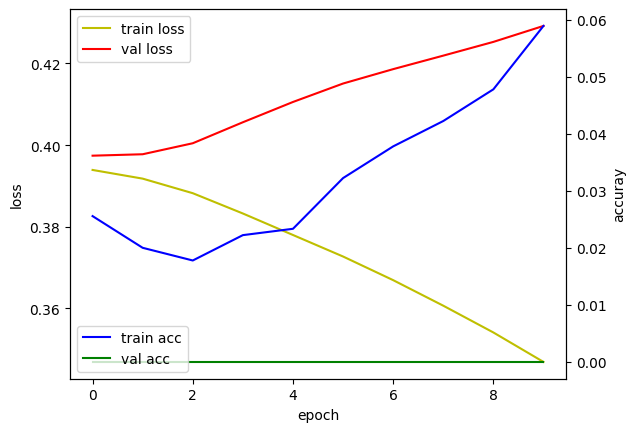

In [51]:
#생략 
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [45]:
# 88회부터 지금까지 1등부터 5등까지 상금의 평균낸다.
mean_prize = [ np.mean(rows[87:, 2]),
           np.mean(rows[87:, 4]),
           np.mean(rows[87:, 6]),
           np.mean(rows[87:, 8]),
           np.mean(rows[87:, 10])]

print(mean_prize)   

[401466263.55452675, 57149973.95781893, 1451604.869341564, 52542.15843621399, 5000.0]


In [46]:
# 등수와 상금을 반환함
# 순위에 오르지 못한 경우에는 등수가 0으로 반환함
def calc_reward(true_numbers, true_bonus, pred_numbers):

    count = 0

    for ps in pred_numbers:
        if ps in true_numbers:
            count += 1

    if count == 6:
        return 0, mean_prize[0]
    elif count == 5 and true_bonus in pred_numbers:
        return 1, mean_prize[1]
    elif count == 5:
        return 2, mean_prize[2]
    elif count == 4:
        return 3, mean_prize[3]
    elif count == 3:
        return 4, mean_prize[4]

    return 5, 0

In [52]:
def gen_numbers_from_probability(nums_prob):

    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        ball_box += list(ball)

    selected_balls = []

    while True:
        
        if len(selected_balls) == 6:
            break
        
        ball_index = np.random.randint(len(ball_box), size=1)[0]
        ball = ball_box[ball_index]

        if ball not in selected_balls:
            selected_balls.append(ball)

    return selected_balls

In [53]:
#생략
train_total_reward = []
train_total_grade = np.zeros(6, dtype=int)

val_total_reward = []
val_total_grade = np.zeros(6, dtype=int)

test_total_reward = []
test_total_grade = np.zeros(6, dtype=int)

model.reset_states()

print('[No. ] 1st 2nd 3rd 4th 5th 6th Rewards')

for i in range(len(x_samples)):
    xs = x_samples[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs) # 모델의 출력값을 얻음
    
    sum_reward = 0
    sum_grade = np.zeros(6, dtype=int) # 6등까지 변수

    for n in range(10): # 10판 수행
        numbers = gen_numbers_from_probability(ys_pred[0])
        
        #i회차 입력 후 나온 출력을 i+1회차와 비교함
        grade, reward = calc_reward(rows[i+1,11:17], rows[i+1,17], numbers) 
        
        sum_reward += reward
        sum_grade[grade] += 1

        if i >= train_idx[0] and i < train_idx[1]:
            train_total_grade[grade] += 1
        elif i >= val_idx[0] and i < val_idx[1]:
            val_total_grade[grade] += 1
        elif i >= test_idx[0] and i < test_idx[1]:
            val_total_grade[grade] += 1
    
    if i >= train_idx[0] and i < train_idx[1]:
        train_total_reward.append(sum_reward)
    elif i >= val_idx[0] and i < val_idx[1]:
        val_total_reward.append(sum_reward)
    elif i >= test_idx[0] and i < test_idx[1]:
        test_total_reward.append(sum_reward)
                        
    print('[{0:4d}] {1:3d} {2:3d} {3:3d} {4:3d} {5:3d} {6:3d} {7:15,d}'.format(i+1, sum_grade[0], sum_grade[1], sum_grade[2], sum_grade[3], sum_grade[4], sum_grade[5], int(sum_reward)))

print('Total') 
print('==========')    
print('Train {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(train_total_grade[0], train_total_grade[1], train_total_grade[2], train_total_grade[3], train_total_grade[4], train_total_grade[5], int(sum(train_total_reward))))
print('Val   {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(val_total_grade[0], val_total_grade[1], val_total_grade[2], val_total_grade[3], val_total_grade[4], val_total_grade[5], int(sum(val_total_reward))))
print('Test  {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(test_total_grade[0], test_total_grade[1], test_total_grade[2], test_total_grade[3], test_total_grade[4], test_total_grade[5], int(sum(test_total_reward))))
print('==========')    

[No. ] 1st 2nd 3rd 4th 5th 6th Rewards
[   1]   0   0   0   0   1   9           5,000
[   2]   0   0   0   3   0   7         157,626
[   3]   0   0   0   1   0   9          52,542
[   4]   0   0   0   0   2   8          10,000
[   5]   0   0   0   0   0  10               0
[   6]   0   0   0   0   4   6          20,000
[   7]   0   0   0   0   2   8          10,000
[   8]   0   0   0   0   1   9           5,000
[   9]   0   0   0   0   0  10               0
[  10]   0   0   0   0   0  10               0
[  11]   0   0   0   1   1   8          57,542
[  12]   0   0   0   0   0  10               0
[  13]   0   0   0   0   0  10               0
[  14]   0   0   0   0   1   9           5,000
[  15]   0   0   0   0   0  10               0
[  16]   0   0   0   0   0  10               0
[  17]   0   0   0   0   0  10               0
[  18]   0   0   0   0   1   9           5,000
[  19]   0   0   0   0   0  10               0
[  20]   0   0   0   0   1   9           5,000
[  21]   0   0   0   

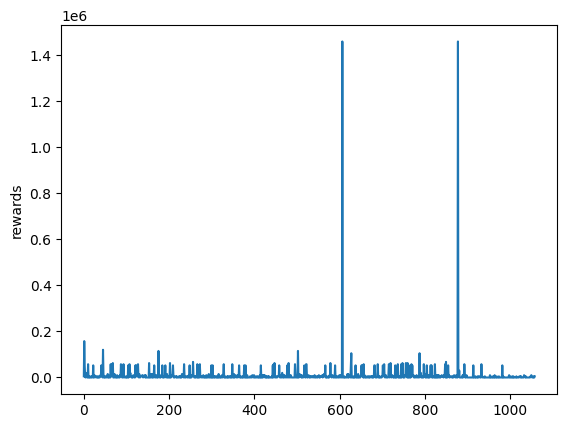

In [54]:
#생략
%matplotlib inline
import matplotlib.pyplot as plt

total_reward = train_total_reward + val_total_reward + test_total_reward

plt.plot(total_reward)
plt.ylabel('rewards')
plt.show()

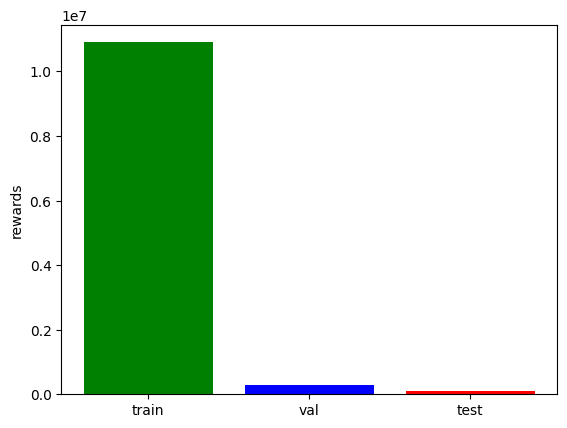

In [55]:
#생략
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

rewards = [sum(train_total_reward), sum(val_total_reward), sum(test_total_reward)]

class_color=['green', 'blue', 'red']

plt.bar(['train', 'val', 'test'], rewards, color=class_color)
plt.ylabel('rewards')
plt.show()

In [56]:
# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    for i in range(len(x_samples)):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss)))  
     

epoch    0 train acc 0.061 loss 0.349
epoch    1 train acc 0.062 loss 0.348
epoch    2 train acc 0.064 loss 0.345
epoch    3 train acc 0.068 loss 0.342
epoch    4 train acc 0.072 loss 0.338
epoch    5 train acc 0.075 loss 0.333
epoch    6 train acc 0.079 loss 0.329
epoch    7 train acc 0.084 loss 0.324
epoch    8 train acc 0.088 loss 0.320
epoch    9 train acc 0.091 loss 0.315
epoch   10 train acc 0.093 loss 0.310
epoch   11 train acc 0.095 loss 0.305
epoch   12 train acc 0.098 loss 0.301
epoch   13 train acc 0.101 loss 0.296
epoch   14 train acc 0.104 loss 0.291
epoch   15 train acc 0.107 loss 0.286
epoch   16 train acc 0.109 loss 0.282
epoch   17 train acc 0.111 loss 0.278
epoch   18 train acc 0.113 loss 0.273
epoch   19 train acc 0.115 loss 0.269
epoch   20 train acc 0.116 loss 0.265
epoch   21 train acc 0.118 loss 0.261
epoch   22 train acc 0.120 loss 0.257
epoch   23 train acc 0.121 loss 0.253
epoch   24 train acc 0.122 loss 0.249
epoch   25 train acc 0.124 loss 0.245
epoch   26 t

In [57]:
# save the trained model
model.save('lottery_model_rnn.h5')

In [58]:
from keras.models import load_model

# load the saved model
model = load_model('lottery_model_rnn.h5')

In [ ]:
# 마지막 회차까지 학습한 모델로 다음 회차 추론

print('receive numbers')

xs = x_samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(1000):
    numbers = gen_numbers_from_probability(ys_pred[0])
    numbers.sort()
    print('{0} : {1}'.format(n, numbers))
    list_numbers.append(numbers)

In [99]:
df_test = pd.DataFrame(list_numbers, columns=[1, 2, 3, 4, 5, 6])
X_test = df_test
print(X_test)

      1   2   3   4   5   6
0     4  20  22  23  32  40
1     3   4  20  25  34  43
2     4  11  20  25  40  43
3     4  20  30  34  40  43
4     4  20  22  25  34  43
..   ..  ..  ..  ..  ..  ..
995   4  20  24  25  29  43
996  12  20  25  40  42  43
997   2   4  17  20  25  43
998   2   4  19  20  25  40
999  20  31  37  40  41  43

[1000 rows x 6 columns]


In [100]:
# train model on entire train data 
y_pred = final_ebm.predict(X_test)  
print(y_pred)
df_test['pred'] = y_pred

[1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 

In [101]:
# 조건 설정
condition = df_test['pred'] == 1

# 조건을 만족하는 행 출력
print(len(df_test[condition]))
df_end = df_test[condition]
df_end = df_end.drop(['pred'], axis=1).astype(int)
print(df_end)


921
      1   2   3   4   5   6
0     4  20  22  23  32  40
1     3   4  20  25  34  43
2     4  11  20  25  40  43
3     4  20  30  34  40  43
4     4  20  22  25  34  43
..   ..  ..  ..  ..  ..  ..
995   4  20  24  25  29  43
996  12  20  25  40  42  43
997   2   4  17  20  25  43
998   2   4  19  20  25  40
999  20  31  37  40  41  43

[921 rows x 6 columns]


In [102]:
count_dict = df_end.apply(pd.Series.value_counts).fillna(0).to_dict('dict')
print(count_dict)


{1: {1: 29.0, 2: 21.0, 3: 25.0, 4: 800.0, 5: 2.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 3.0, 11: 1.0, 12: 3.0, 13: 1.0, 14: 4.0, 15: 1.0, 16: 3.0, 17: 2.0, 18: 1.0, 19: 0.0, 20: 19.0, 21: 0.0, 22: 2.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0}, 2: {1: 0.0, 2: 1.0, 3: 0.0, 4: 67.0, 5: 26.0, 6: 26.0, 7: 22.0, 8: 19.0, 9: 22.0, 10: 15.0, 11: 16.0, 12: 11.0, 13: 18.0, 14: 15.0, 15: 17.0, 16: 22.0, 17: 113.0, 18: 16.0, 19: 16.0, 20: 434.0, 21: 2.0, 22: 30.0, 23: 1.0, 24: 1.0, 25: 8.0, 26: 0.0, 27: 0.0, 28: 1.0, 29: 0.0, 30: 0.0, 31: 1.0, 32: 0.0, 33: 0.0, 34: 1.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0}, 3: {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 1.0, 6: 0.0, 7: 1.0, 8: 2.0, 9: 1.0, 10: 1.0, 11: 4.0, 12: 4.0, 13: 3.0, 14: 4.0, 15: 3.0, 16: 2.0, 17: 41.0, 18: 3.0, 19: 10.0, 20:

In [103]:
# assume you have a two-dimensional dictionary named "data_dict" with n keys and m keys for each key
data_sums = {}

# iterate over each key-value pair in the outer dictionary
for outer_key, outer_value in count_dict.items():
    # iterate over each key-value pair in the inner dictionary
    for inner_key, inner_value in outer_value.items():
        # check if the inner key is already in the data_sums dictionary
        if inner_key in data_sums:
            # add the inner value to the existing sum for this data value
            data_sums[inner_key] += inner_value
        else:
            # create a new key in the data_sums dictionary and set its value to the inner value
            data_sums[inner_key] = inner_value

# print the data sums
print(data_sums)

{1: 29.0, 2: 22.0, 3: 25.0, 4: 867.0, 5: 29.0, 6: 27.0, 7: 24.0, 8: 22.0, 9: 24.0, 10: 19.0, 11: 21.0, 12: 18.0, 13: 22.0, 14: 23.0, 15: 22.0, 16: 27.0, 17: 158.0, 18: 20.0, 19: 26.0, 20: 854.0, 21: 9.0, 22: 446.0, 23: 29.0, 24: 32.0, 25: 583.0, 26: 17.0, 27: 28.0, 28: 25.0, 29: 21.0, 30: 23.0, 31: 29.0, 32: 20.0, 33: 28.0, 34: 439.0, 35: 23.0, 36: 147.0, 37: 22.0, 38: 27.0, 39: 21.0, 40: 599.0, 41: 31.0, 42: 28.0, 43: 570.0, 44: 28.0, 45: 22.0}


In [106]:
sorted_dict = dict(sorted(data_sums.items(), key=lambda item: item[1], reverse=True))

# print the sorted dictionary
print(sorted_dict)

{4: 867.0, 20: 854.0, 40: 599.0, 25: 583.0, 43: 570.0, 22: 446.0, 34: 439.0, 17: 158.0, 36: 147.0, 24: 32.0, 41: 31.0, 1: 29.0, 5: 29.0, 23: 29.0, 31: 29.0, 27: 28.0, 33: 28.0, 42: 28.0, 44: 28.0, 6: 27.0, 16: 27.0, 38: 27.0, 19: 26.0, 3: 25.0, 28: 25.0, 7: 24.0, 9: 24.0, 14: 23.0, 30: 23.0, 35: 23.0, 2: 22.0, 8: 22.0, 13: 22.0, 15: 22.0, 37: 22.0, 45: 22.0, 11: 21.0, 29: 21.0, 39: 21.0, 18: 20.0, 32: 20.0, 10: 19.0, 12: 18.0, 26: 17.0, 21: 9.0}


In [107]:
# iterate over the first 10 items in the sorted list and print the keys and values
count = 0
for key, value in sorted_dict.items():
    if count < 10:
        print(f"{key}: {value}")
        count += 1
    else:
        break

4: 867.0
20: 854.0
40: 599.0
25: 583.0
43: 570.0
22: 446.0
34: 439.0
17: 158.0
36: 147.0
24: 32.0


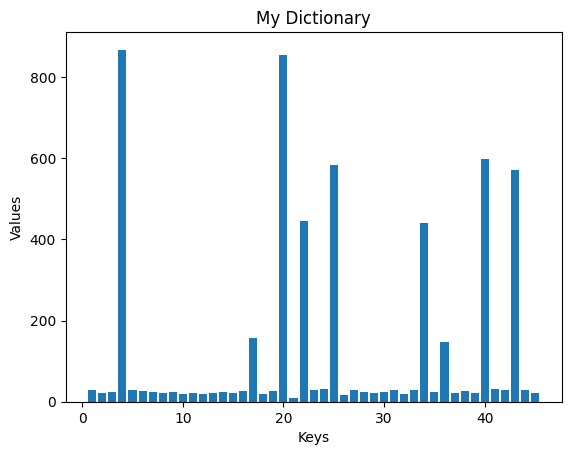

In [108]:
import matplotlib.pyplot as plt

# assume you have a dictionary named "my_dict"
# get the keys and values from the dictionary
keys = list(sorted_dict.keys())
values = list(sorted_dict.values())

# create a bar chart of the values
plt.bar(keys, values)

# add labels to the x and y axes
plt.xlabel('Keys')
plt.ylabel('Values')

# add a title to the chart
plt.title('My Dictionary')

# display the chart
plt.show()